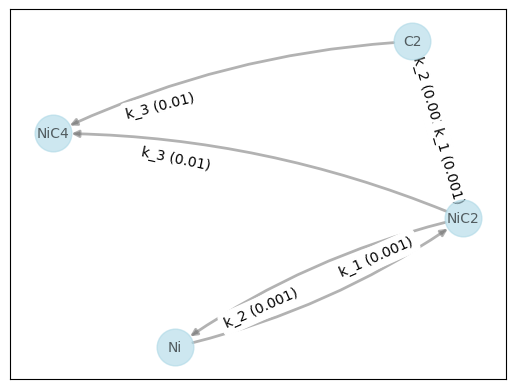

{'Ni': [(('NiC2',), 0.001), (('Ni', 'C2'), -0.001)],
 'NiC2': [(('Ni', 'C2'), 0.001), (('NiC2',), -0.001), (('NiC2', 'C2'), -0.01)],
 'C2': [(('NiC2',), 0.001), (('Ni', 'C2'), -0.001), (('NiC2', 'C2'), -0.01)],
 'NiC4': [(('NiC2', 'C2'), 0.01)]}

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

class Reaction:
    def __init__(self, reactions) -> None:
        self.reactions = reactions
        self.create_edges()
        self.G = nx.DiGraph()
        self.G.add_edges_from(self.edges)

    def create_edges(self):
        self.edges = []
        reaction_type_counter = 0

        for reaction in self.reactions:
            reaction_type_counter += 1
            reactants, products = reaction[0].split('<->') if '<->' in reaction[0] else reaction[0].split('->')
            rate_constants = reaction[1:]
            
            reactants = reactants.strip().split(' + ')
            products = products.strip().split(' + ')

            for reactant in reactants:
                for product in products:
                    self.edges.append((reactant.strip(), product.strip(), {'weight': rate_constants[0], 'type': f'k_{reaction_type_counter}'}))

            if '<->' in reaction[0] and len(rate_constants) > 1:
                reaction_type_counter += 1
                for reactant in reactants:
                    for product in products:
                        self.edges.append((product.strip(), reactant.strip(), {'weight': rate_constants[1], 'type': f'k_{reaction_type_counter}'}))


    def create_reaction_dict(self):
        reaction_dict = {}

        for node in self.G.nodes():
            in_edges = self.G.in_edges(node, data=True)
            out_edges = self.G.out_edges(node, data=True)

            type_groups = {}
            for u, v, data in in_edges:
                reaction_type = data['type']
                rate_constant = data['weight']

                if reaction_type not in type_groups:
                    type_groups[reaction_type] = {'nodes': set(), 'rate': rate_constant}
                type_groups[reaction_type]['nodes'].add(u)

            for u, v, data in out_edges:
                reaction_type = data['type']
                rate_constant = -data['weight']
                
                if reaction_type not in type_groups:
                    type_groups[reaction_type] = {'nodes': set(), 'rate': rate_constant}
                type_groups[reaction_type]['nodes'].add(node)

                neighbors_in_edges = self.G.in_edges(v, data=True)
                for nu, nv, ndata in neighbors_in_edges:
                    if ndata['type'] == reaction_type and nu != node:
                        type_groups[reaction_type]['nodes'].add(nu)
                
            reaction_dict[node] = [(tuple(group['nodes']), group['rate']) for group in type_groups.values()]

        return reaction_dict



    def plot_graph(self):
        pos = nx.spring_layout(self.G)
        nx.draw_networkx(self.G, pos, with_labels=True, connectionstyle='arc3,rad=0.1', 
                         node_size=700, node_color='lightblue', font_size=10, font_color='black', 
                         edge_color='gray', width=2, alpha=0.6)

        # Отображаем стрелки, указывающие направление
        nx.draw_networkx_edge_labels(self.G, pos, 
                                     edge_labels={(u, v): f"{d['type']} ({d['weight']})" for u, v, d in self.G.edges(data=True)}, 
                                     label_pos=0.3)
        
        plt.show()


reaction_list = [['Ni + C2 <-> NiC2', 1e-3, 1e-3],
                 ['NiC2 + C2 -> NiC4', 1e-2]]


reaction = Reaction(reaction_list)
reaction.plot_graph()
reaction.create_reaction_dict()